In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np

sns.set()

In [2]:
all_dfs = []
for f in glob('../data/*.json'):
    all_dfs.append(pd.read_json(open(f)))
df = pd.concat(all_dfs)

In [19]:
def output_nlines(output):
    return len(set(sum([list(range(rng['start_line'], rng['end_line']+1)) for rng in output], [])))
df['nlines'] = df.output.map(output_nlines)

def function_nlines(rng):
    return len(range(rng['start_line'], rng['end_line']+1))
df['func_nlines'] = df.function.map(function_nlines)

df['slice_offset'] = df.apply(lambda row: row.slice['start_line'] - row.function['start_line'], axis=1)

In [20]:
df['slice_key'] = df.slice.map(lambda s: hash(frozenset(s.items())))

In [28]:
deltas = df.groupby('slice_key', as_index=False).apply(lambda g: pd.DataFrame([{
    'delta': g[g['mode'] == 'LikeC'].iloc[0].nlines - g[g['mode'] == 'Standard'].iloc[0].nlines,
    'slice': g.iloc[0].slice,
    'orig_size': g[g['mode'] == 'Standard'].iloc[0].nlines,
    'func_size': g.iloc[0].func_nlines,
    'slice_offset': g.iloc[0].slice_offset
}]))
deltas

,,delta,slice,orig_size,func_size,slice_offset
0,0,6,"{'start_line': 428, 'start_col': 8, 'end_line'...",37,120,105
1,0,0,"{'start_line': 22752, 'start_col': 12, 'end_li...",6,12,5
2,0,0,"{'start_line': 147, 'start_col': 4, 'end_line'...",0,1,2
3,0,0,"{'start_line': 637, 'start_col': 33, 'end_line...",11,51,9
4,0,0,"{'start_line': 881, 'start_col': 12, 'end_line...",5,21,2
...,...,...,...,...,...,...
3328,0,0,"{'start_line': 31, 'start_col': 8, 'end_line':...",2,9,1
3329,0,0,"{'start_line': 313, 'start_col': 20, 'end_line...",49,87,55
3330,0,0,"{'start_line': 432, 'start_col': 12, 'end_line...",2,19,9
3331,0,0,"{'start_line': 31400, 'start_col': 12, 'end_li...",3,9,5


In [29]:
for i in range(10):
    x = deltas.sort_values(['delta', 'orig_size']).iloc[-(i+1)]
    print('orig_size', x.orig_size, 'delta', x.delta)
    print(f'{x.slice["filename"]}:{x.slice["start_line"]+1}')

orig_size 5 delta 163
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:813
orig_size 5 delta 163
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:813
orig_size 30 delta 155
/Users/will/Code/rust-slicer/data/repos/rg3d/src/renderer/mod.rs:1068
orig_size 4 delta 122
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:812
orig_size 4 delta 122
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:812
orig_size 4 delta 122
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:811
orig_size 5 delta 120
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:769
orig_size 5 delta 120
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:769
orig_size 116 delta 102
/Users/will/Code/rust-slicer/data/repos/rg3d/src/renderer/ui_renderer.rs:297
orig_size 4 delta 99
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs:767


In [30]:
deltas['func_bin'] = deltas.func_size // 20 * 20

<AxesSubplot:xlabel='func_bin', ylabel='delta'>

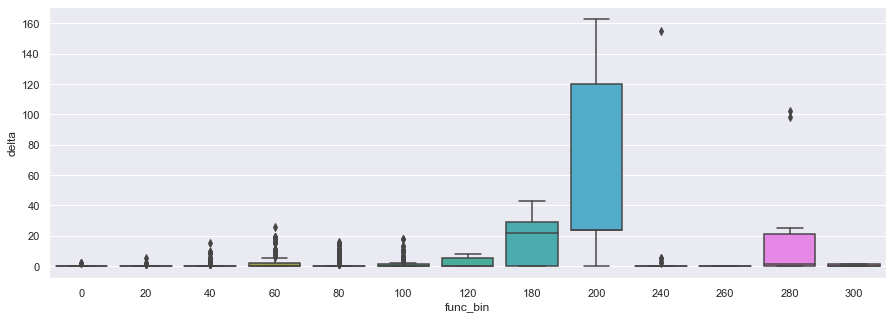

In [32]:
plt.figure(figsize=(15, 5))
deltas_filtered = deltas[(deltas.slice_offset > 10) & (deltas.func_bin < 400)]
sns.boxplot(data=deltas_filtered, x='func_bin', y='delta', )

In [33]:
deltas_filtered.groupby('func_bin').delta.describe()[['count', '50%', 'mean', 'std']]

,count,50%,mean,std
func_bin,,,,
0,69.0,0.0,0.086957,0.410850
20,92.0,0.0,0.206522,0.671852
40,277.0,0.0,0.761733,1.937683
60,156.0,0.0,3.134615,5.817755
80,210.0,0.0,1.528571,3.581136
100,195.0,0.0,1.317949,2.875678
120,87.0,0.0,2.137931,2.588761
180,21.0,22.0,16.190476,16.311404
200,25.0,24.0,60.280000,54.585193
